In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [9]:
#importing required libraries
import random
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score


In [10]:
np.random.seed(42)

In [11]:
#total classes
classes = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

In [12]:
train_dataset_path = '/kaggle/input/dataset/Alzheimer_s Dataset/train'
test_dataset_path = '/kaggle/input/dataset/Alzheimer_s Dataset/test'

## Loading the Dataset

In [7]:
def get_dataset(dataset_path, batch_size=32, image_size=(224, 224)):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=image_size,
    )
    return train_dataset

In [8]:
train_dataset = get_dataset(train_dataset_path)

Found 5121 files belonging to 4 classes.


In [9]:
test_dataset = get_dataset(test_dataset_path)

Found 1279 files belonging to 4 classes.


## Plot the Images

In [10]:
def plot_images(train_dataset, num_images_per_class=4):
    class_names = train_dataset.class_names
    images_by_class = {class_name: [] for class_name in class_names}
    for images, labels in train_dataset:
        for image, label in zip(images, labels):
            class_name = class_names[tf.argmax(label)]
            images_by_class[class_name].append(image)
    for class_name, class_images in images_by_class.items():
        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Class: {class_name}', fontsize=16)
        for i, image in enumerate(class_images[:num_images_per_class]):
            plt.subplot(1, num_images_per_class, i + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.axis("off")
        plt.tight_layout() 
        plt.show()

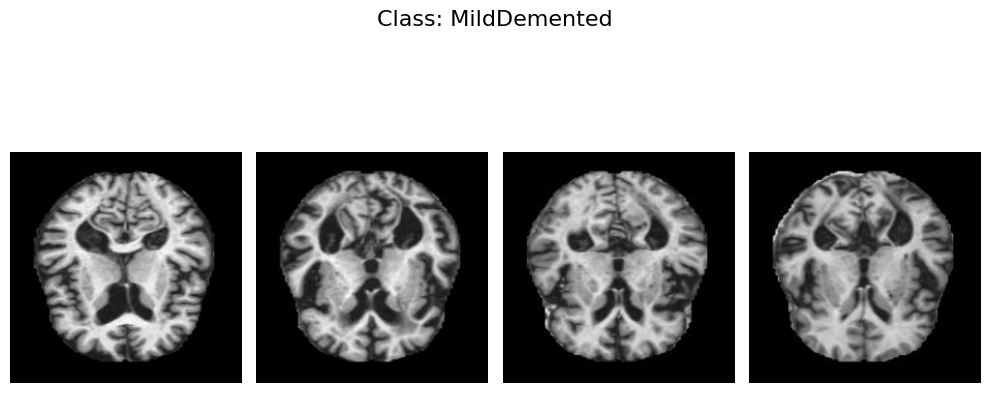

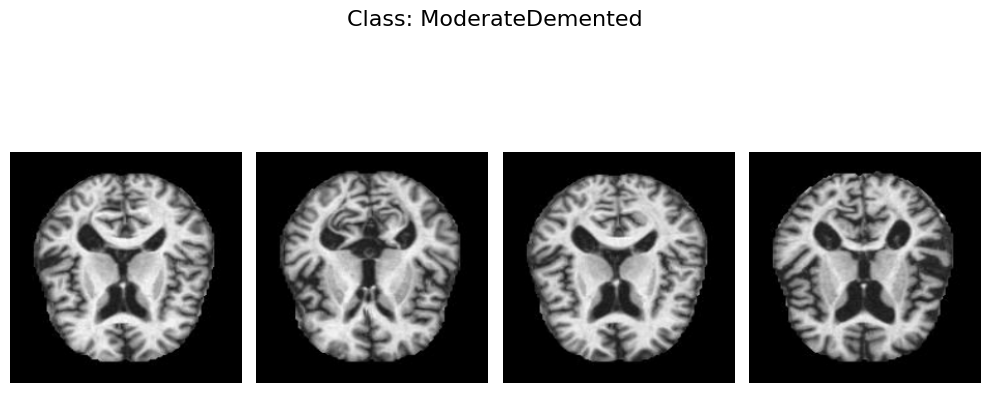

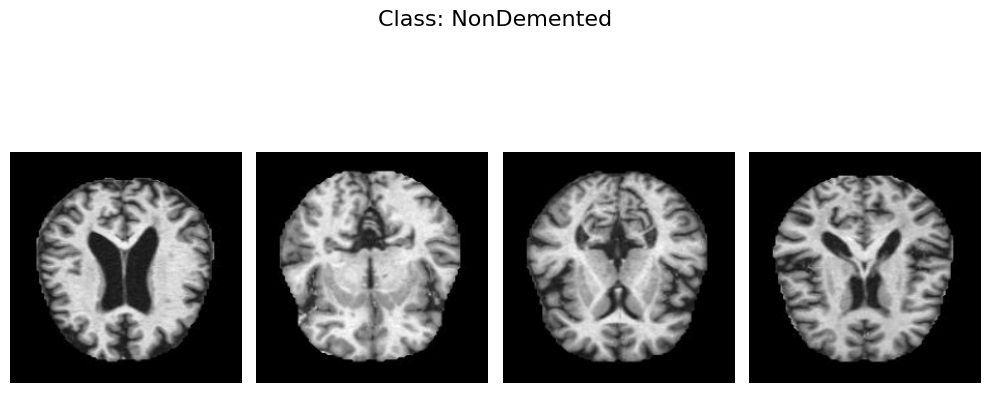

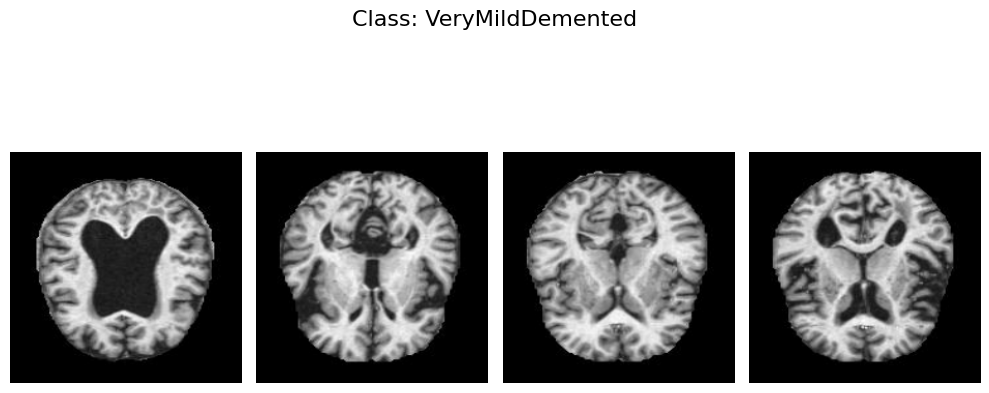

In [11]:
plot_images(train_dataset)

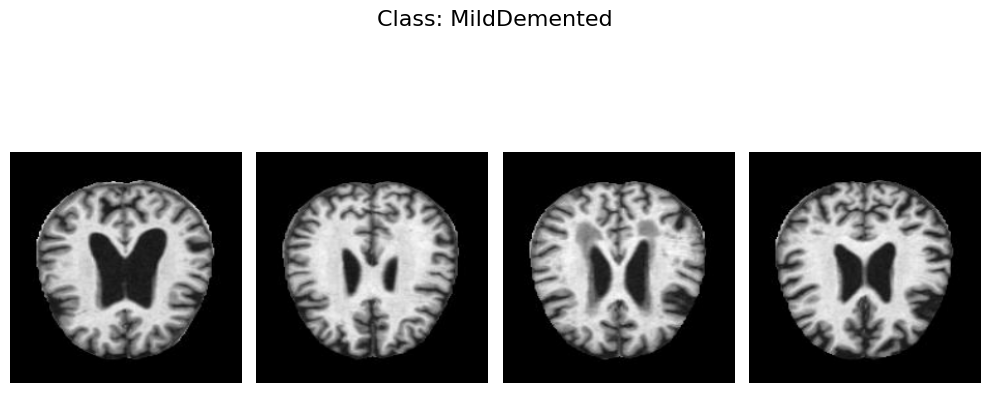

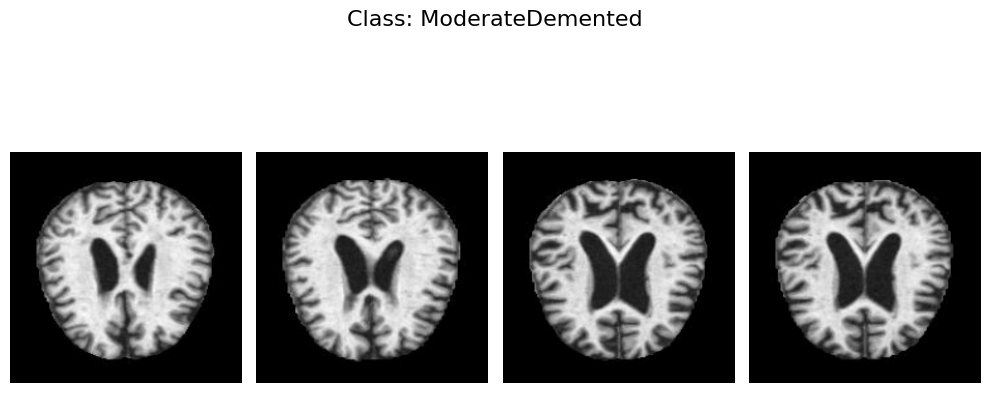

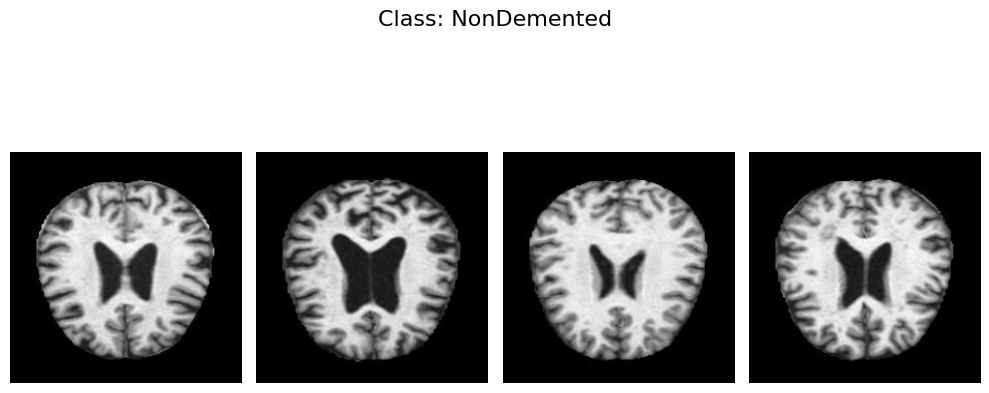

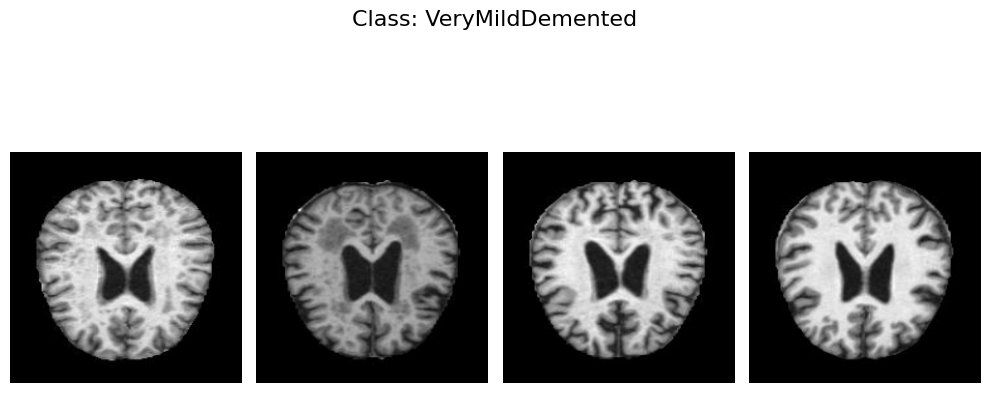

In [12]:
plot_images(test_dataset)

In [13]:
class_names = train_dataset.class_names

In [14]:
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [15]:
class_counts = {class_name: 0 for class_name in class_names}

In [16]:
# Count the number of samples for each class
for images, labels in train_dataset:
    for label in labels:
        class_name = class_names[label.numpy().argmax()]
        class_counts[class_name] += 1

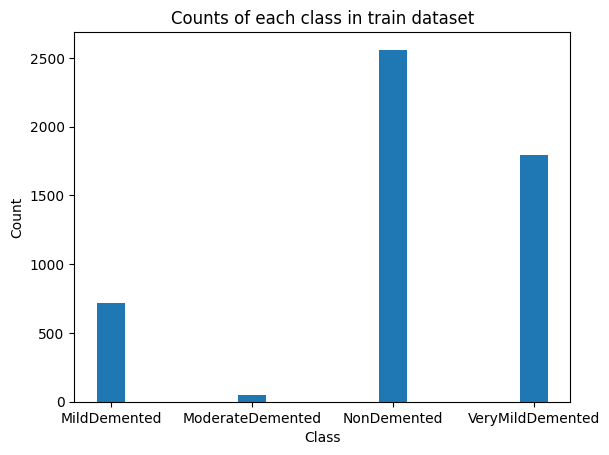

In [17]:
plt.bar(class_counts.keys(), class_counts.values(),width=0.2)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Counts of each class in train dataset')
plt.show()

### From the plot, we can see that Moderate Demented is the minority classs and Non Demented is majority class.

In [18]:
class_counts

{'MildDemented': 717,
 'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792}

In [19]:
max_count = max(class_counts.values())

In [20]:
max_count

2560

## Lets apply class weights and importance techniques to get balance the dataset

# Data Augmentation

In [21]:
target_shape = (224,224)
batch_size = 128

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_dataset = train_datagen.flow_from_directory(
    directory=train_dataset_path,
    target_size=target_shape,
    class_mode='categorical',
    subset='training',
    batch_size=batch_size
)

Found 4098 images belonging to 4 classes.


In [25]:
validation_dataset = train_datagen.flow_from_directory(
    directory=train_dataset_path,
    target_size=target_shape,
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size
)

Found 1023 images belonging to 4 classes.


In [26]:
test_dataset = test_datagen.flow_from_directory(
    directory=test_dataset_path,
    target_size=target_shape,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1279 images belonging to 4 classes.


In [27]:
from sklearn.utils.class_weight import compute_class_weight

In [28]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_dataset.classes), y= train_dataset.classes)

In [29]:
class_weights
class_weight_dict = dict(enumerate(class_weights))

In [30]:
class_weight_dict

{0: 1.7848432055749128,
 1: 24.392857142857142,
 2: 0.500244140625,
 3: 0.7144351464435147}

# 1. We will be using VGG16 as our Transfer learning model

In [31]:
vgg16 = VGG16(input_shape=(target_shape[0],target_shape[1], 3),include_top=False,weights="imagenet")

In [32]:
#stop training the layers again

vgg16.trainable = False

In [33]:
# Input layer
input_layer = Input(shape=(target_shape[0], target_shape[1], 3))
x = vgg16(input_layer)  # Connect the input to the VGG16 model

# Custom layers
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(4, activation='softmax')(x)

# Creating the model
model = Model(inputs=input_layer, outputs=output_layer)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                             

In [35]:
model.compile(
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        #tf.keras.metrics.F1Score(name='f1_score'),
    ],
    optimizer=tf.keras.optimizers.Adam(lr=0.001)
)

In [36]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_auc',mode='max',patience=15,verbose=1),
        ModelCheckpoint('./best_vgg16model.hdf5',monitor='val_auc',mode='max',save_best_only=True,verbose=1)
    ],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/100


2023-11-23 06:01:11.738257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - ETA: 0s - loss: 2.1889 - auc: 0.5839 - precision: 0.3134 - recall: 0.2408
Epoch 1: val_auc improved from -inf to 0.68730, saving model to ./best_vgg16model.hdf5
33/33 [==============================] - 101s 2s/step - loss: 2.1889 - auc: 0.5839 - precision: 0.3134 - recall: 0.2408 - val_loss: 2.2879 - val_auc: 0.6873 - val_precision: 0.3627 - val_recall: 0.3304
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.8213 - auc: 0.8314 - precision: 0.6118 - recall: 0.4929
Epoch 16: val_auc did not improve from 0.72060
33/33 [==============================] - 63s 2s/step - loss: 0.8213 - auc: 0.8314 - precision: 0.6118 - recall: 0.4929 - val_loss: 1.3133 - val_auc: 0.7180 - val_precision: 0.4180 - val_recall: 0.3089
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.8587 - auc: 0.8298 - precision: 0.6165 - recall: 0.4822
Epoch 17: val_auc improved from 0.72060 to 0.73261, saving model to ./best_vgg16model.hdf5
33

In [37]:
#Loading the Best Model

from tensorflow.keras.models import load_model

# Load the best model from the saved .hdf5 file
best_model = load_model('./best_vgg16model.hdf5')

In [79]:
def evaluate(model,model_history,dataset=None):
    #plotting the model accuracy vs epochs
    plt.plot(model_history.history['auc'])
    plt.plot(model_history.history['val_auc'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    
    #plotting the model loss vs epochs
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    ##Evaluating the model
    loss,acc, precision,recall = model.evaluate(dataset)
    
    # Accuracy
    print(f'Test Accuracy: {acc*100:.4f}')
    
    # Precision
    print(f'Weighted Precision: {precision:.4f}')

    # Recall
    print(f'Weighted Recall: {recall:.4f}')
    
    #Loss
    print(f'Test Loss: {loss:.4f}')
    
    
    
    #classification report
    y_true = dataset.classes
    y_pred = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    class_labels = list(dataset.class_indices.keys())
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    #f1 score
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(f'Weighted F1 Score: {f1:.4f}')
    
    
    #heatmap of classification report
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


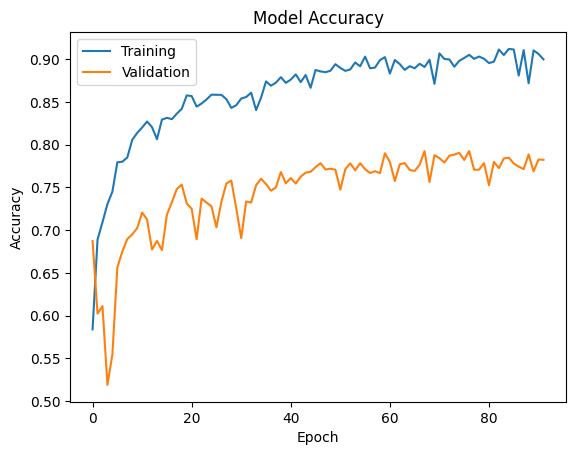

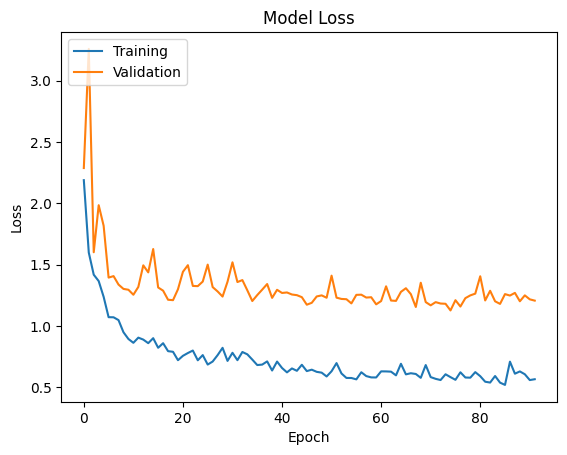

10/10 [==============================] - 6s 506ms/step - loss: 0.7668 - auc: 0.8996 - precision: 0.6912 - recall: 0.6161
Test Accuracy: 89.9637
Weighted Precision: 0.6912
Weighted Recall: 0.6161
Test Loss: 0.7668
10/10 [==============================] - 5s 509ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.12      0.08      0.10       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.51      0.51      0.51       640
VeryMildDemented       0.34      0.38      0.35       448

        accuracy                           0.40      1279
       macro avg       0.24      0.24      0.24      1279
    weighted avg       0.39      0.40      0.39      1279

Weighted F1 Score: 0.3909


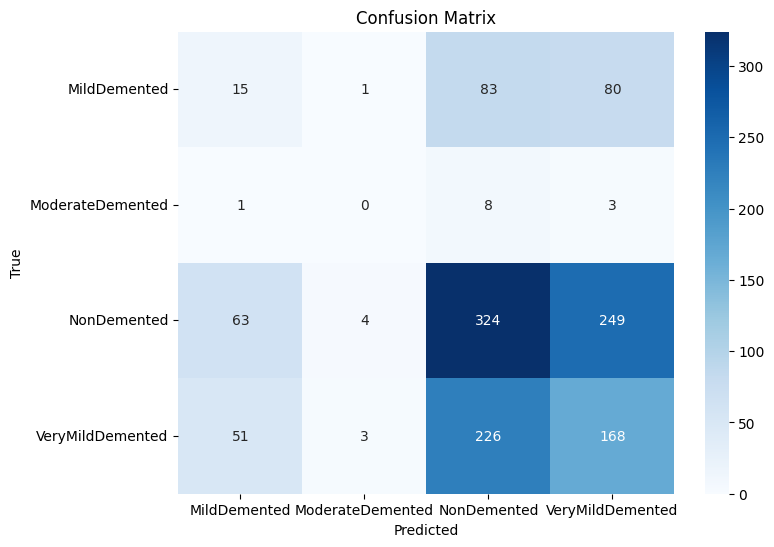

In [39]:
evaluate(best_model,history,dataset=test_dataset)

#### From above reports, we can say that the model is performing well but the accuracy of model with respect to the minority class labels is not working properly.

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation

# 2. Model using Dense Layers ( DNN)

In [41]:

# Creating the model
dense_model = Sequential()

# Input layer
dense_model.add(Flatten(input_shape=(target_shape[0], target_shape[1], 3)))

# Custom layers
dense_model.add(Dropout(0.5))
dense_model.add(Dense(2048, kernel_initializer='he_uniform'))
dense_model.add(BatchNormalization())
dense_model.add(Activation('relu'))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(1024, kernel_initializer='he_uniform'))
dense_model.add(BatchNormalization())
dense_model.add(Activation('relu'))
dense_model.add(Dropout(0.5))

# Output layer
dense_model.add(Dense(4, activation='softmax'))

# model summary
dense_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dropout_3 (Dropout)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 2048)              308283392 
                                                                 
 batch_normalization_3 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                        

In [42]:
dense_model.compile(
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        #tf.keras.metrics.F1Score(name='f1_score'),
    ],
    optimizer=tf.keras.optimizers.Adam(lr=0.001)
)

## Testing before training

In [43]:
dense_model.evaluate(test_dataset)

10/10 [==============================] - 4s 323ms/step - loss: 1.6226 - auc: 0.4172 - precision: 0.3156 - recall: 0.1900


[1.622552514076233,
 0.4171644449234009,
 0.3155844211578369,
 0.18999217450618744]

In [44]:
# Training the model
dense_model_history = dense_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_auc',mode='max',patience=15,verbose=1),
        ModelCheckpoint('./best_dnnmodel.hdf5',monitor='val_auc',mode='max',save_best_only=True,verbose=1)
    ],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 2.0138 - auc: 0.6066 - precision: 0.3495 - recall: 0.2545
Epoch 1: val_auc improved from -inf to 0.66699, saving model to ./best_dnnmodel.hdf5
33/33 [==============================] - 69s 2s/step - loss: 2.0138 - auc: 0.6066 - precision: 0.3495 - recall: 0.2545 - val_loss: 24.9209 - val_auc: 0.6670 - val_precision: 0.5005 - val_recall: 0.5005
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.9169 - auc: 0.6283 - precision: 0.3866 - recall: 0.2584
Epoch 2: val_auc improved from 0.66699 to 0.66911, saving model to ./best_dnnmodel.hdf5
33/33 [==============================] - 69s 2s/step - loss: 1.9169 - auc: 0.6283 - precision: 0.3866 - recall: 0.2584 - val_loss: 11.4006 - val_auc: 0.6691 - val_precision: 0.5005 - val_recall: 0.5005
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.8621 - auc: 0.6014 - precision: 0.3615 - recall: 0.2277
Epoch 3: val_auc improved from 0.66911 to 

#### Loading the best model

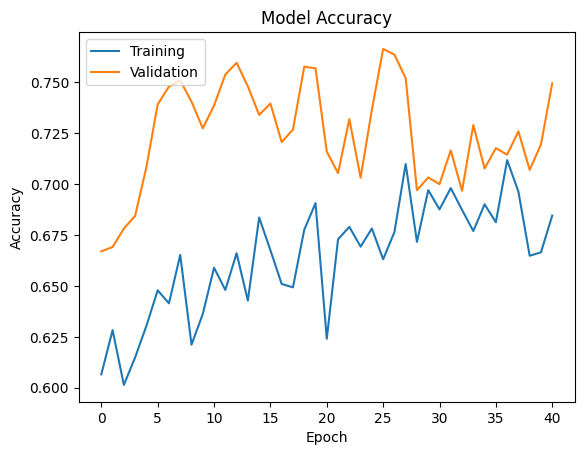

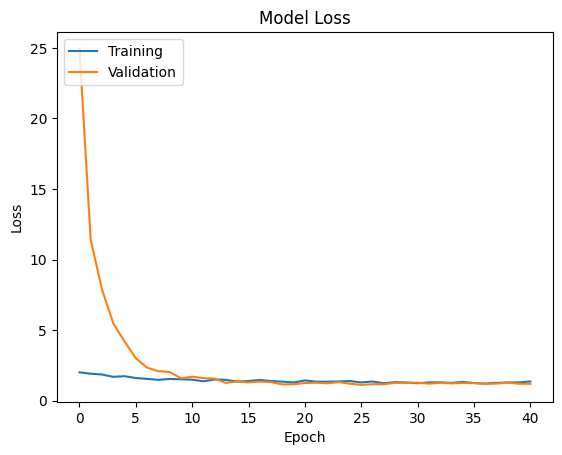

10/10 [==============================] - 4s 445ms/step - loss: 1.2884 - auc: 0.7937 - precision: 0.6029 - recall: 0.3597
Test Accuracy: 79.3727
Weighted Precision: 0.6029
Weighted Recall: 0.3597
Test Loss: 1.2884
10/10 [==============================] - 3s 333ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.18      0.17      0.17       179
ModerateDemented       0.06      0.08      0.07        12
     NonDemented       0.49      0.62      0.55       640
VeryMildDemented       0.35      0.23      0.28       448

        accuracy                           0.42      1279
       macro avg       0.27      0.28      0.27      1279
    weighted avg       0.40      0.42      0.40      1279

Weighted F1 Score: 0.3981


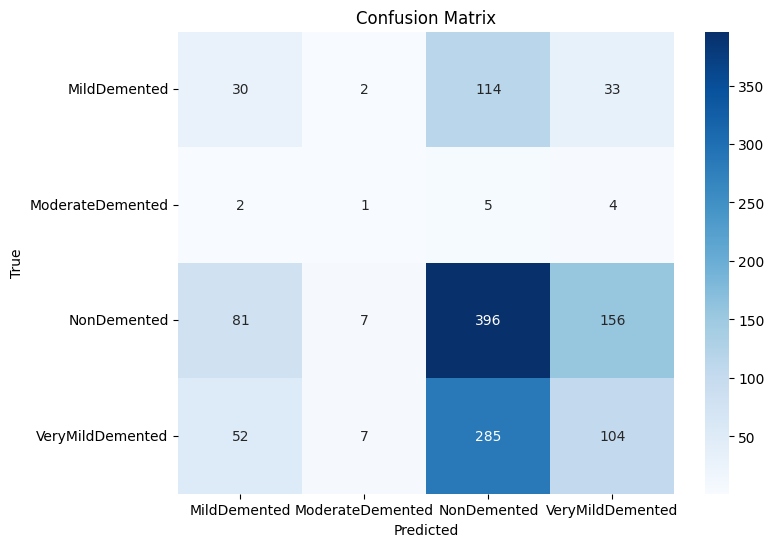

In [45]:
evaluate(dense_model,dense_model_history,dataset=test_dataset)

### We can observe that the dnn model is not working well with NonDemented data but not with all other classes. This indicates that the class weights technique is not resulting in a good model.

# Now, we will implement the next Student Model ( CNN model) in a different way. We will combine the both train and test samples and handle the class imbalance and then train the model.

In [5]:
DATASET_DIR = './dataset'

In [8]:
# Creating dataset folder and class subfolders
if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)
for c in classes:
    os.mkdir(os.path.join(DATASET_DIR, c))

In [9]:
# Moving train images
for c in classes:
    source_dir = os.path.join(train_dataset_path, c)
    dest_dir = os.path.join(DATASET_DIR, c) 
    files = os.listdir(source_dir)
    
    for f in files:
        source_path = os.path.join(source_dir, f)
        dest_path = os.path.join(dest_dir, f)
        shutil.copy(source_path, dest_path)

In [10]:
# Moving test images        
for c in classes:
    source_dir = os.path.join(test_dataset_path, c)
    dest_dir = os.path.join(DATASET_DIR, c)
    files = os.listdir(source_dir)
    
    for f in files:
        source_path = os.path.join(source_dir, f)
        dest_path = os.path.join(dest_dir, f) 
        shutil.copy(source_path, dest_path)

In [11]:
#count the updated 
for c in classes:
    dir_path = os.path.join(DATASET_DIR, c)
    files = os.listdir(dir_path)
    num_files = len(files)
    
    print(f"{c}: {num_files}")

MildDemented: 896
ModerateDemented: 64
NonDemented: 3200
VeryMildDemented: 2240


In [158]:
img_height =128
img_width = 128
channels = 3

In [159]:
dataset = tf.keras.utils.image_dataset_from_directory(DATASET_DIR,
                                                   batch_size=32,
                                                   image_size=(img_height, img_width),
                                                   shuffle=True,
                                                   seed=42)

Found 6400 files belonging to 4 classes.


In [160]:
num_classes = len(classes)

In [161]:
#normalization
dataset = dataset.map(lambda x, y: (tf.image.per_image_standardization(x), y))

### Train, Test and validation split

In [162]:
def train_test_val_split(data, train_size, val_size, test_size):
        train = int(len(data) * train_size)
        test = int(len(data) * test_size)
        val = int(len(data) * val_size)
        train_data = data.take(train)
        val_data = data.skip(train).take(val)
        test_data = data.skip(train + val).take(test)
        return train_data, val_data, test_data

In [163]:
train_data, val_data, test_data = train_test_val_split(dataset, train_size=0.8, val_size=0.1, test_size=0.1)

In [164]:
train_labels = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)

In [165]:
# Using sklearn's compute_class_weight to calculate class weights
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.numpy())

In [166]:
# Creating a dictionary mapping class indices to their respective weights
class_weights = dict(zip(np.unique(y_train), class_weight))

In [167]:
class_weights

{0: 1.755829903978052,
 1: 26.122448979591837,
 2: 0.49883086515978176,
 3: 0.7207207207207207}

# 3. Model Creation - Student Designed Model

In [168]:
model = Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(img_height, img_height, channels)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(4, activation="softmax")
    ])

In [169]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [170]:
 model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 14, 14, 128)     

In [171]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=[
        ModelCheckpoint(
            filepath="./best_cnn.hdf5",
            save_weights_only=False,
            save_freq='epoch',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1
        )
    ]
)


Epoch 1/20
158/160 [============================>.] - ETA: 0s - loss: 1.4372 - accuracy: 0.1871
Epoch 1: val_accuracy improved from -inf to 0.01875, saving model to ./best_cnn.hdf5
160/160 [==============================] - 6s 22ms/step - loss: 1.4379 - accuracy: 0.1850 - val_loss: 1.4831 - val_accuracy: 0.0188
Epoch 2/20
159/160 [============================>.] - ETA: 0s - loss: 1.3698 - accuracy: 0.2433
Epoch 2: val_accuracy improved from 0.01875 to 0.14219, saving model to ./best_cnn.hdf5
160/160 [==============================] - 3s 21ms/step - loss: 1.3731 - accuracy: 0.2426 - val_loss: 1.4498 - val_accuracy: 0.1422
Epoch 3/20
158/160 [============================>.] - ETA: 0s - loss: 1.2271 - accuracy: 0.4242
Epoch 3: val_accuracy improved from 0.14219 to 0.35156, saving model to ./best_cnn.hdf5
160/160 [==============================] - 3s 21ms/step - loss: 1.2323 - accuracy: 0.4254 - val_loss: 1.7624 - val_accuracy: 0.3516
Epoch 4/20
157/160 [============================>.] - E

### Model Evaluation of CNN Model

In [174]:
from sklearn.metrics import precision_recall_fscore_support


In [175]:
def evaluate(model,history):
    #plotting the model accuracy vs epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    #plotting the model loss vs epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_data)

    # Display accuracy and loss
    print(f'Test Accuracy: {test_accuracy*100:.4f}')
    print(f'Test Loss: {test_loss:.4f}')

    # Display classification report
    predictions = []
    labels = []

    for X, y in test_data.as_numpy_iterator():
        y_pred = model.predict(X, verbose=0)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions.extend(y_prediction)
        labels.extend(y)

    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate precision, recall, and F1 score
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}')
    print(classification_report(labels, predictions, target_names=classes))
    # Display confusion matrix
    cm = confusion_matrix(labels, predictions)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True, fmt=".1f")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

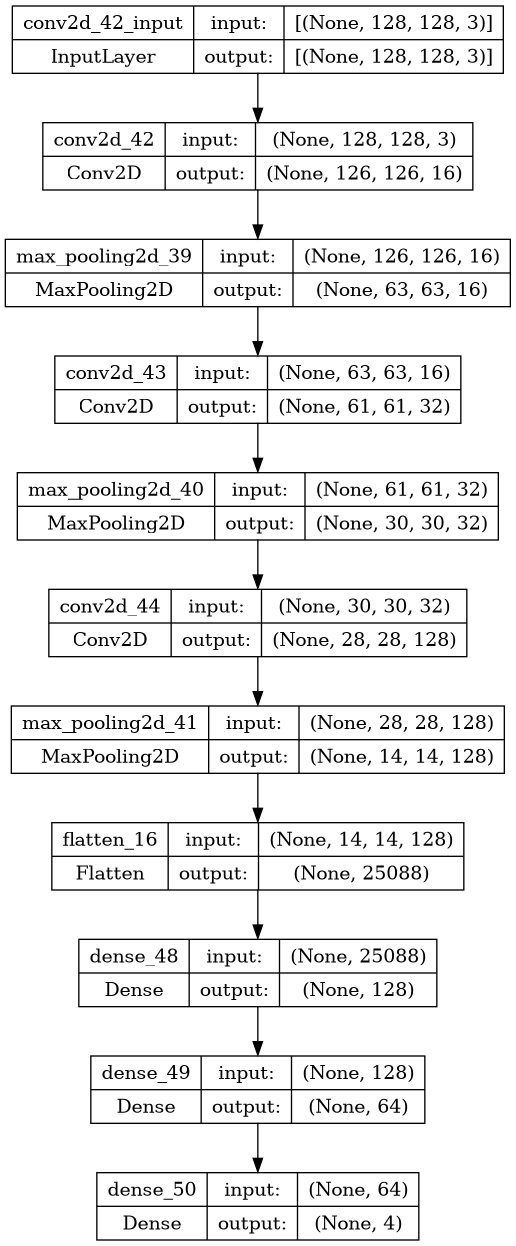

In [191]:
plot_model(model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)

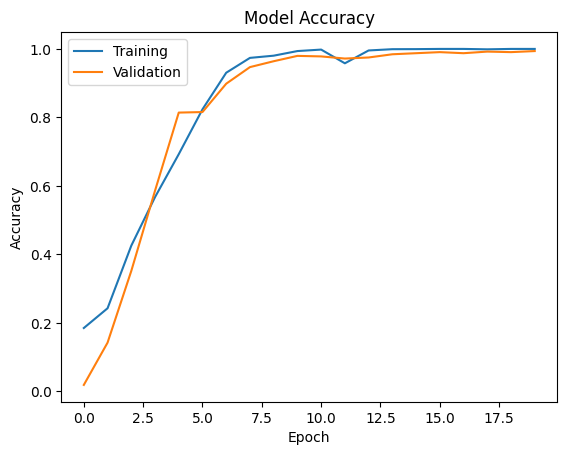

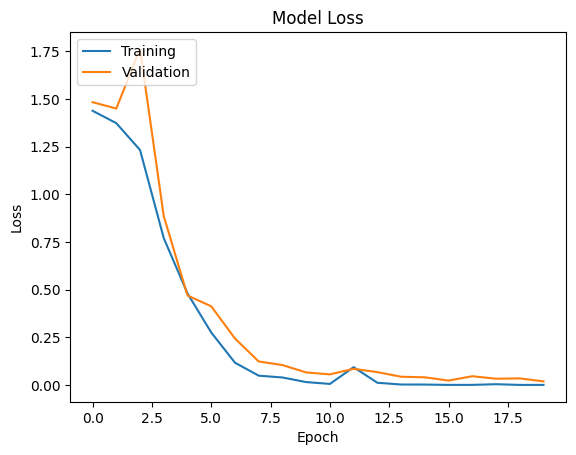

20/20 [==============================] - 1s 10ms/step - loss: 0.0294 - accuracy: 0.9922
Test Accuracy: 99.2188
Test Loss: 0.0294
Precision: 0.9891
Recall: 0.9891
F1 Score: 0.9891
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00        84
ModerateDemented       1.00      1.00      1.00         5
     NonDemented       0.99      0.99      0.99       316
VeryMildDemented       0.99      0.98      0.99       235

        accuracy                           0.99       640
       macro avg       0.99      0.99      0.99       640
    weighted avg       0.99      0.99      0.99       640



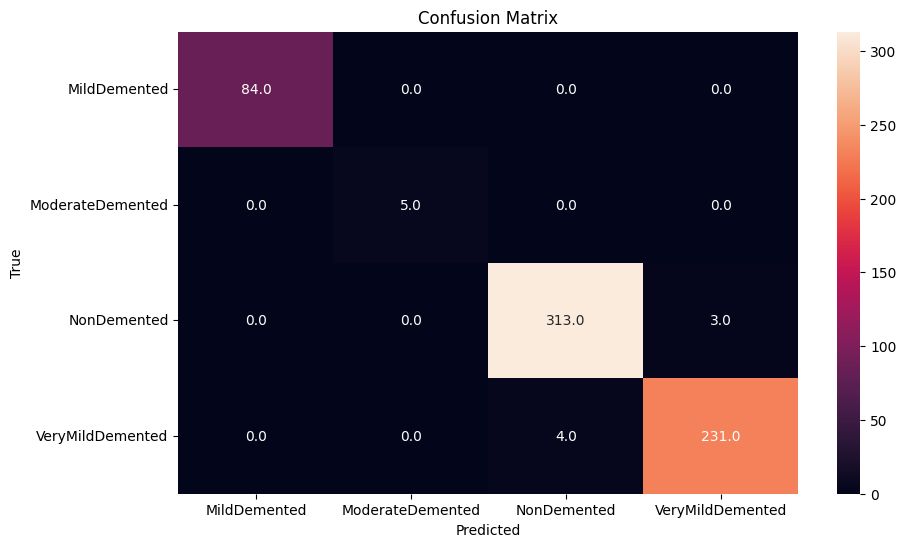

In [176]:
evaluate(model,history)

### Looks like this method is working well with the dataset. Now, we can implement a transfer learning model on this.

# Transfer Learning Model

In [180]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))
base_model.trainable = False
    
model_TF = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    
model_TF.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_TF.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_19 (Flatten)        (None, 8192)              0         
                                                                 
 dense_57 (Dense)            (None, 128)               1048704   
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dense_59 (Dense)            (None, 4)                 260       
                                                                 
Total params: 15771908 (60.17 MB)
Trainable params: 1057220 (4.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [181]:
history_TF = model_TF.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=[
        ModelCheckpoint(
            filepath="./best_TF.hdf5",
            save_weights_only=False,
            save_freq='epoch',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1
        )
    ]
)


Epoch 1/20
159/160 [============================>.] - ETA: 0s - loss: 1.4588 - accuracy: 0.3318
Epoch 1: val_accuracy improved from -inf to 0.29375, saving model to ./best_TF.hdf5
160/160 [==============================] - 12s 56ms/step - loss: 1.4595 - accuracy: 0.3311 - val_loss: 1.3377 - val_accuracy: 0.2937
Epoch 2/20
159/160 [============================>.] - ETA: 0s - loss: 1.1112 - accuracy: 0.4461
Epoch 2: val_accuracy did not improve from 0.29375
160/160 [==============================] - 9s 54ms/step - loss: 1.1130 - accuracy: 0.4461 - val_loss: 1.4412 - val_accuracy: 0.2781
Epoch 3/20
159/160 [============================>.] - ETA: 0s - loss: 0.8540 - accuracy: 0.5252
Epoch 3: val_accuracy improved from 0.29375 to 0.56250, saving model to ./best_TF.hdf5
160/160 [==============================] - 9s 55ms/step - loss: 0.8525 - accuracy: 0.5256 - val_loss: 0.9600 - val_accuracy: 0.5625
Epoch 4/20
159/160 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.59

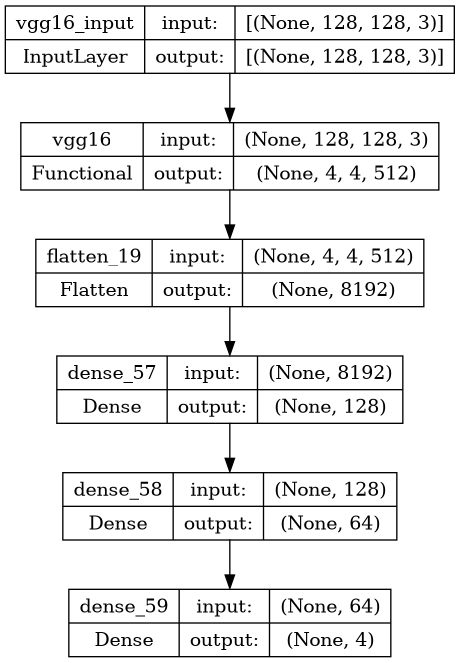

In [190]:
plot_model(model_TF, to_file='model_TF_plot.png', show_shapes=True, show_layer_names=True)

### Evaluating TF Model

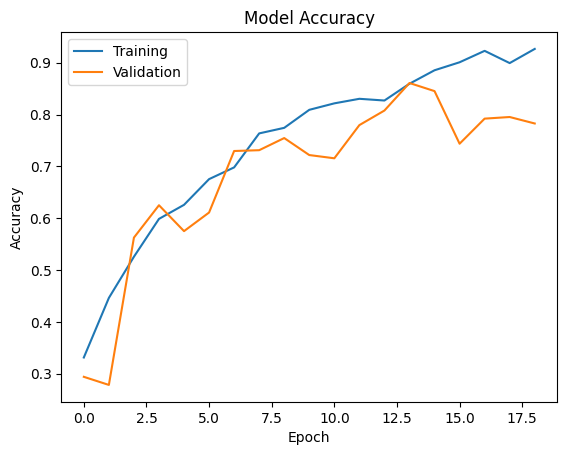

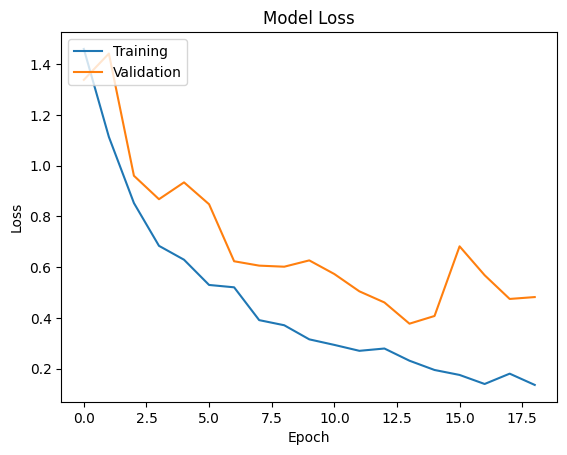

20/20 [==============================] - 2s 43ms/step - loss: 0.5941 - accuracy: 0.7578
Test Accuracy: 75.7812
Test Loss: 0.5941
Precision: 0.8043
Recall: 0.7609
F1 Score: 0.7350
                  precision    recall  f1-score   support

    MildDemented       0.77      0.89      0.82        82
ModerateDemented       0.83      1.00      0.91         5
     NonDemented       0.72      0.97      0.83       325
VeryMildDemented       0.94      0.41      0.57       228

        accuracy                           0.76       640
       macro avg       0.81      0.82      0.78       640
    weighted avg       0.80      0.76      0.73       640



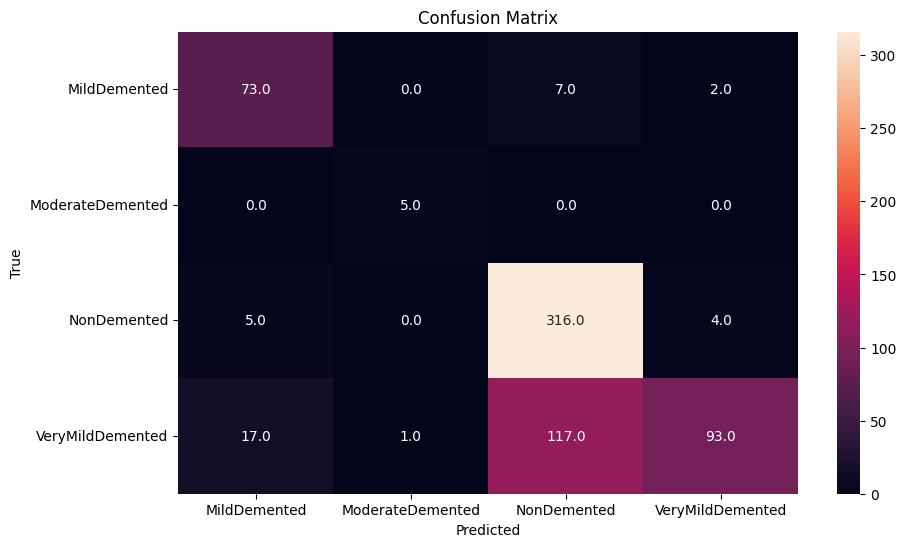

In [182]:
evaluate(model_TF,history_TF)

## DNN Model

In [183]:
DNNmodel = Sequential()
DNNmodel.add(Flatten(input_shape=(img_height, img_width, channels)))
DNNmodel.add(Dense(256, activation="relu"))
DNNmodel.add(Dense(128, activation="relu"))
DNNmodel.add(Dense(64, activation="relu"))
DNNmodel.add(Dense(4, activation="softmax"))
DNNmodel.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
DNNmodel.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 49152)             0         
                                                                 
 dense_60 (Dense)            (None, 256)               12583168  
                                                                 
 dense_61 (Dense)            (None, 128)               32896     
                                                                 
 dense_62 (Dense)            (None, 64)                8256      
                                                                 
 dense_63 (Dense)            (None, 4)                 260       
                                                                 
Total params: 12624580 (48.16 MB)
Trainable params: 12624580 (48.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [184]:
history_DNN = DNNmodel.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=[
        ModelCheckpoint(
            filepath="./best_DNNmodel.hdf5",
            save_weights_only=False,
            save_freq='epoch',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1
        )
    ]
)


Epoch 1/20
157/160 [============================>.] - ETA: 0s - loss: 6.5506 - accuracy: 0.3595
Epoch 1: val_accuracy improved from -inf to 0.50937, saving model to ./best_DNNmodel.hdf5
160/160 [==============================] - 5s 20ms/step - loss: 6.4606 - accuracy: 0.3615 - val_loss: 1.5812 - val_accuracy: 0.5094
Epoch 2/20
155/160 [============================>.] - ETA: 0s - loss: 1.5540 - accuracy: 0.4796
Epoch 2: val_accuracy improved from 0.50937 to 0.65781, saving model to ./best_DNNmodel.hdf5
160/160 [==============================] - 3s 20ms/step - loss: 1.5376 - accuracy: 0.4822 - val_loss: 0.7267 - val_accuracy: 0.6578
Epoch 3/20
160/160 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.6195
Epoch 3: val_accuracy did not improve from 0.65781
160/160 [==============================] - 3s 18ms/step - loss: 0.6432 - accuracy: 0.6195 - val_loss: 0.7732 - val_accuracy: 0.6172
Epoch 4/20
157/160 [============================>.] - ETA: 0s - loss: 0.5521 - acc

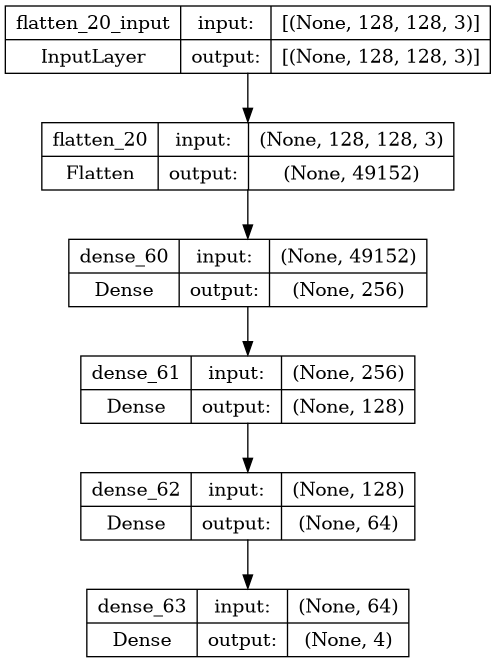

In [188]:
plot_model(DNNmodel, to_file='dnn_model_plot.png', show_shapes=True, show_layer_names=True)

## Evaluating DNN Model

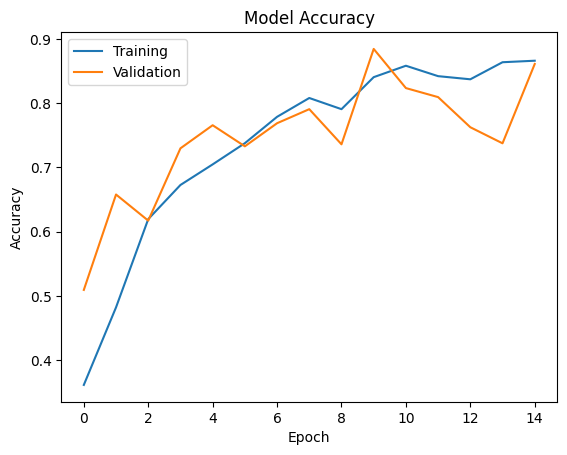

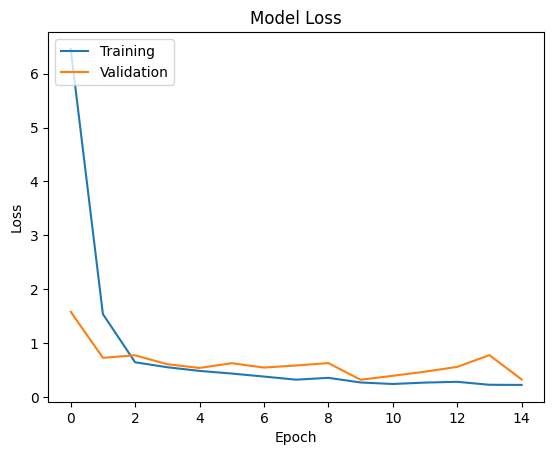

20/20 [==============================] - 1s 7ms/step - loss: 0.3701 - accuracy: 0.8328
Test Accuracy: 83.2812
Test Loss: 0.3701
Precision: 0.8589
Recall: 0.8375
F1 Score: 0.8387
                  precision    recall  f1-score   support

    MildDemented       0.69      0.96      0.80        82
ModerateDemented       1.00      1.00      1.00         4
     NonDemented       0.95      0.76      0.84       315
VeryMildDemented       0.79      0.90      0.84       239

        accuracy                           0.84       640
       macro avg       0.86      0.90      0.87       640
    weighted avg       0.86      0.84      0.84       640



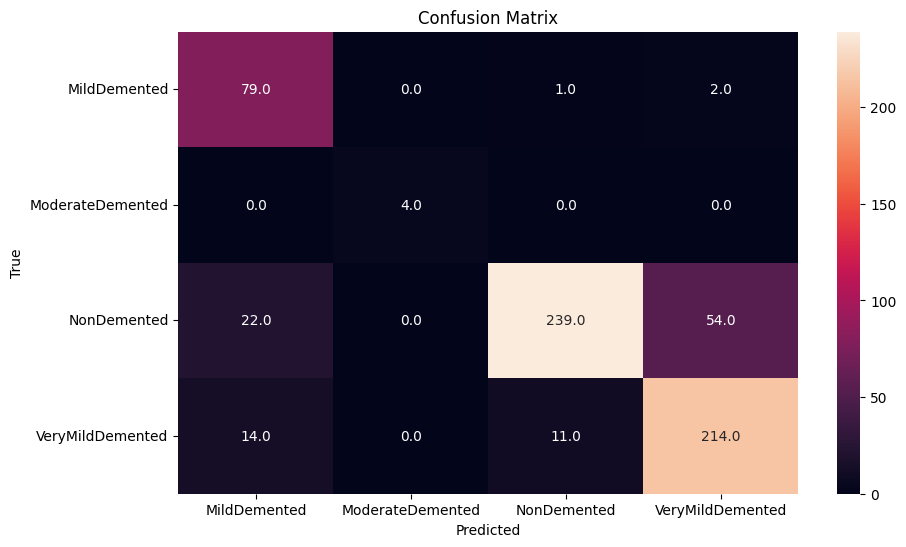

In [185]:
evaluate(DNNmodel,history_DNN)

![](https://cdn.paperpile.com/guides/img/thesis-conclusion-400x400.png)

## Report of VGG 16 MODEL using class weights technique:
Test Accuracy: 89.9637 %

Weighted Precision: 0.6912

Weighted Recall: 0.6161

Test Loss: 0.7668

Classification Report:
                  
                  precision    recall  f1-score   support

    MildDemented       0.12      0.08      0.10       179
    ModerateDemented   0.00      0.00      0.00        12
     NonDemented       0.51      0.51      0.51       640
    VeryMildDemented   0.34      0.38      0.35       448

        accuracy                           0.40      1279
       macro avg       0.24      0.24      0.24      1279
    weighted avg       0.39      0.40      0.39      1279

Weighted F1 Score: 0.3909


## Report of Custom DNN Model using class weights technique:
10/10 [==============================] - 4s 445ms/step - loss: 1.2884 - auc: 0.7937 - precision: 0.6029 - recall: 0.3597

Test Accuracy: 79.3727

Weighted Precision: 0.6029

Weighted Recall: 0.3597

Test Loss: 1.2884

10/10 [==============================] - 3s 333ms/step

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.18      0.17      0.17       179
    ModerateDemented   0.06      0.08      0.07        12
     NonDemented       0.49      0.62      0.55       640
    VeryMildDemented   0.35      0.23      0.28       448

        accuracy                           0.42      1279
       macro avg       0.27      0.28      0.27      1279
    weighted avg       0.40      0.42      0.40      1279

Weighted F1 Score: 0.3981


### 1. Report VGG16 Model using Combined dataset and class weights:
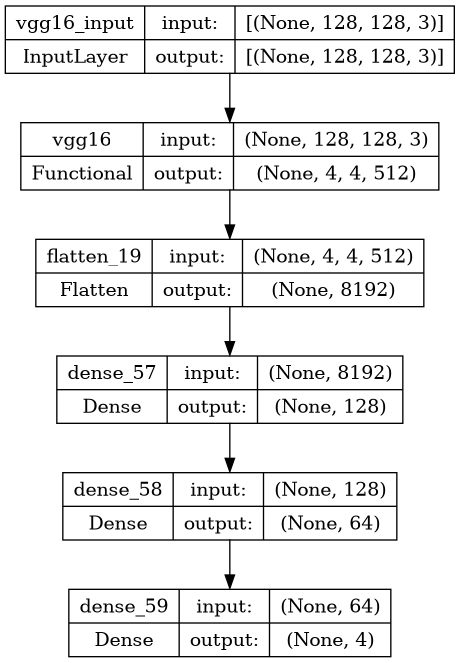
20/20 [==============================] - 2s 43ms/step - loss: 0.5941 - accuracy: 0.7578

Test Accuracy: 75.7812

Test Loss: 0.5941

Precision: 0.8043

Recall: 0.7609

F1 Score: 0.7350
                  
                  precision    recall  f1-score   support

    MildDemented       0.77      0.89      0.82        82
    ModerateDemented   0.83      1.00      0.91         5
     NonDemented       0.72      0.97      0.83       325
    VeryMildDemented   0.94      0.41      0.57       228

        accuracy                           0.76       640
       macro avg       0.81      0.82      0.78       640
    weighted avg       0.80      0.76      0.73       640
    
### 2. Report DNN Model using Combined dataset and class weights:
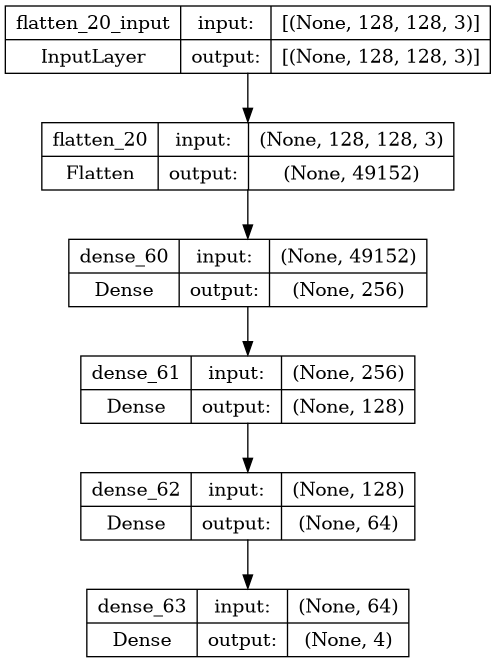


    
    
    





/n 20/20 [==============================] - 1s 7ms/step - loss: 0.3701 - accuracy: 0.8328

Test Accuracy: 83.2812

Test Loss: 0.3701

Precision: 0.8589

Recall: 0.8375

F1 Score: 0.8387

                  precision    recall  f1-score   support

    MildDemented       0.69      0.96      0.80        82
    ModerateDemented   1.00      1.00      1.00         4
     NonDemented       0.95      0.76      0.84       315
    VeryMildDemented   0.79      0.90      0.84       239

        accuracy                           0.84       640
       macro avg       0.86      0.90      0.87       640
    weighted avg       0.86      0.84      0.84       640

### 3. Report of Student Designed Model (CNN Layered Model) using Combined dataset and class weights:

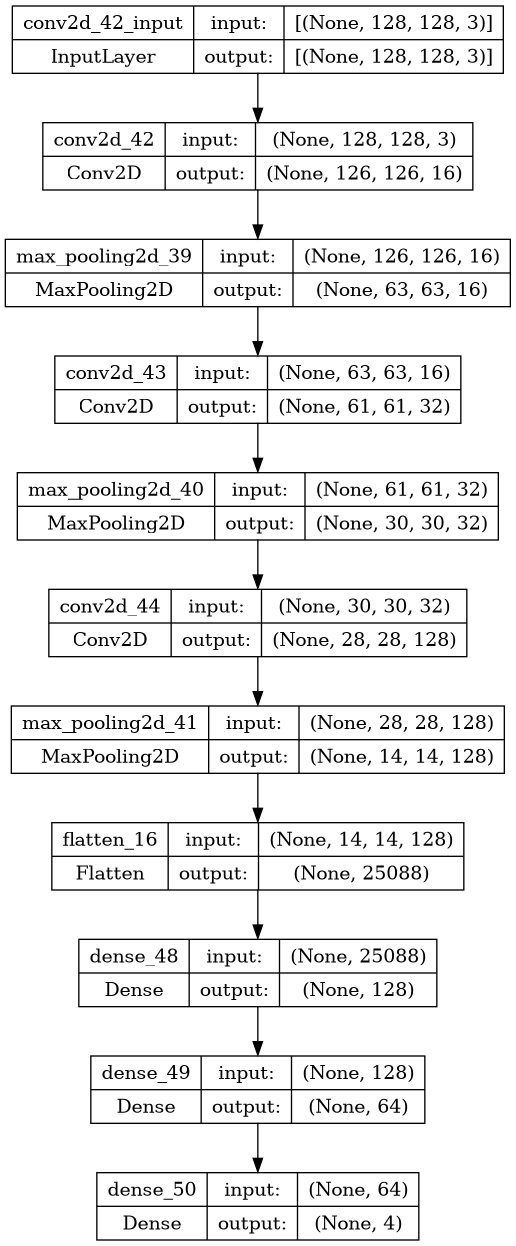

20/20 [==============================] - 1s 10ms/step - loss: 0.0294 - accuracy: 0.9922

Test Accuracy: 99.2188

Test Loss: 0.0294

Precision: 0.9891

Recall: 0.9891

F1 Score: 0.9891
                  
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00        84
    ModerateDemented   1.00      1.00      1.00         5
     NonDemented       0.99      0.99      0.99       316
    VeryMildDemented   0.99      0.98      0.99       235

        accuracy                           0.99       640
       macro avg       0.99      0.99      0.99       640
    weighted avg       0.99      0.99      0.99       640
  

# Final Conclusions

**VGG16 Model:**
* Test Accuracy: 75.78%
* Weighted Precision: 0.8043
* Weighted Recall: 0.7609
* Test Loss: 0.5941
* Classification Report:
    1. Moderate performance across classes.
    2. Relatively high precision and recall for MildDemented.
    3. Poor performance for VeryMildDemented.

**Custom DNN Model:**
* Test Accuracy: 83.28%
* Weighted Precision: 0.8589
* Weighted Recall: 0.8375
* Test Loss: 0.3701
* Classification Report:
    1. Improved performance compared to VGG16.
    2. High precision and recall for ModerateDemented.
    3. Good balance between precision and recall for NonDemented and VeryMildDemented.

**Student-Designed CNN Model:**
* Test Accuracy: 99.22%
* Weighted Precision: 0.9891
* Weighted Recall: 0.9891
* Test Loss: 0.0294
* Classification Report:
    1. Excellent overall performance, indicating a well-designed model.
    2. High precision and recall for all classes, especially for MildDemented.